In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten,Bidirectional
from keras.layers import Dense, Dropout

import mlflow

In [2]:
import pathlib
mlflow_path = pathlib.Path('../../mlruns').resolve()

mlflow.set_tracking_uri(mlflow_path)
mlflow.tensorflow.autolog()
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

In [3]:
df_2022 = pd.read_csv('../../Tweet_Sentiment/BIST100/2022_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()
df_2021 = pd.read_csv('../../Tweet_Sentiment/BIST100/2021_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()

In [4]:
df = pd.concat([df_2022, df_2021]).sort_index()
df

,şimdi,açılış,avg_polar
Unnamed: 0,,,
2021-01-04,1495.43,1482.17,0.598575
2021-01-05,1489.56,1492.19,0.543668
2021-01-06,1505.42,1501.61,0.557471
2021-01-07,1522.24,1511.60,0.535849
2021-01-08,1540.61,1526.51,0.562334
...,...,...,...
2022-10-12,3517.75,3576.84,0.488859
2022-10-13,3553.43,3529.78,0.497640
2022-10-14,3626.96,3584.94,0.479313


In [5]:
scaler = MinMaxScaler()
scaler = scaler.fit(df.iloc[:-30, :])
df_for_training_scaled = scaler.transform(df)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit(pd.DataFrame(df.iloc[:-30,0]))

MinMaxScaler()

In [6]:
df_for_training_scaled

array([[0.08003785, 0.07858764, 0.72105409],
       [0.07718958, 0.08344814, 0.57273265],
       [0.08488524, 0.08801758, 0.61001957],
       ...,
       [1.11430928, 1.09859715, 0.39888659],
       [1.22137901, 1.12598471, 0.53515469],
       [1.21843855, 1.2260177 , 0.44597785]])

In [7]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (443, 5, 3).
TrainY shape = (443, 1, 1).


In [8]:
X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=30, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=30, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((413, 5, 2), (413, 5, 3))

In [9]:
def build_model(input_shape):
    tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [10]:
cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=80, batch_size=64, verbose=1)

history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=80, batch_size=64, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

2022/12/16 18:11:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '60d01410f7954040a843af6f16ef32d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/80
7/7 [==============================] - 11s 74ms/step - loss: 0.0774
Epoch 2/80
7/7 [==============================] - 0s 24ms/step - loss: 0.0157
Epoch 3/80
7/7 [==============================] - 0s 16ms/step - loss: 0.0128
Epoch 4/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0052
Epoch 5/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0033
Epoch 6/80
7/7 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 7/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 8/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 9/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0010
Epoch 10/80
7/7 [==============================] - 0s 14ms/step - loss: 9.2097e-04
Epoch 11/80
7/7 [==============================] - 0s 14ms/step - loss: 9.5835e-04
Epoch 12/80
7/7 [==============================] - 0s 14ms/step - loss: 9.2697e-04
Epoch 13/80
7/7 [==============================]

2022/12/16 18:12:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\assas\anaconda3\envs\tf\lib\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: C:\Users\assas\AppData\Local\Temp\tmpcpgusxhv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\assas\AppData\Local\Temp\tmpcpgusxhv\model\data\model\assets
2022/12/16 18:12:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\assas\anaconda3\envs\tf\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2022/12/16 18:12:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '553bcd0a75db452fa7d47e06ad3aa1d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/80
7/7 [==============================] - 5s 83ms/step - loss: 0.0796
Epoch 2/80
7/7 [==============================] - 0s 28ms/step - loss: 0.0179
Epoch 3/80
7/7 [==============================] - 0s 21ms/step - loss: 0.0077
Epoch 4/80
7/7 [==============================] - 0s 20ms/step - loss: 0.0045
Epoch 5/80
7/7 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 6/80
7/7 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 7/80
7/7 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 8/80
7/7 [==============================] - 0s 19ms/step - loss: 0.0014
Epoch 9/80
7/7 [==============================] - 0s 19ms/step - loss: 0.0014
Epoch 10/80
7/7 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 11/80
7/7 [==============================] - 0s 19ms/step - loss: 9.7382e-04
Epoch 12/80
7/7 [==============================] - 0s 20ms/step - loss: 9.8718e-04
Epoch 13/80
7/7 [==============================] - 0s

2022/12/16 18:12:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\assas\anaconda3\envs\tf\lib\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: C:\Users\assas\AppData\Local\Temp\tmp07fsyn2m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\assas\AppData\Local\Temp\tmp07fsyn2m\model\data\model\assets


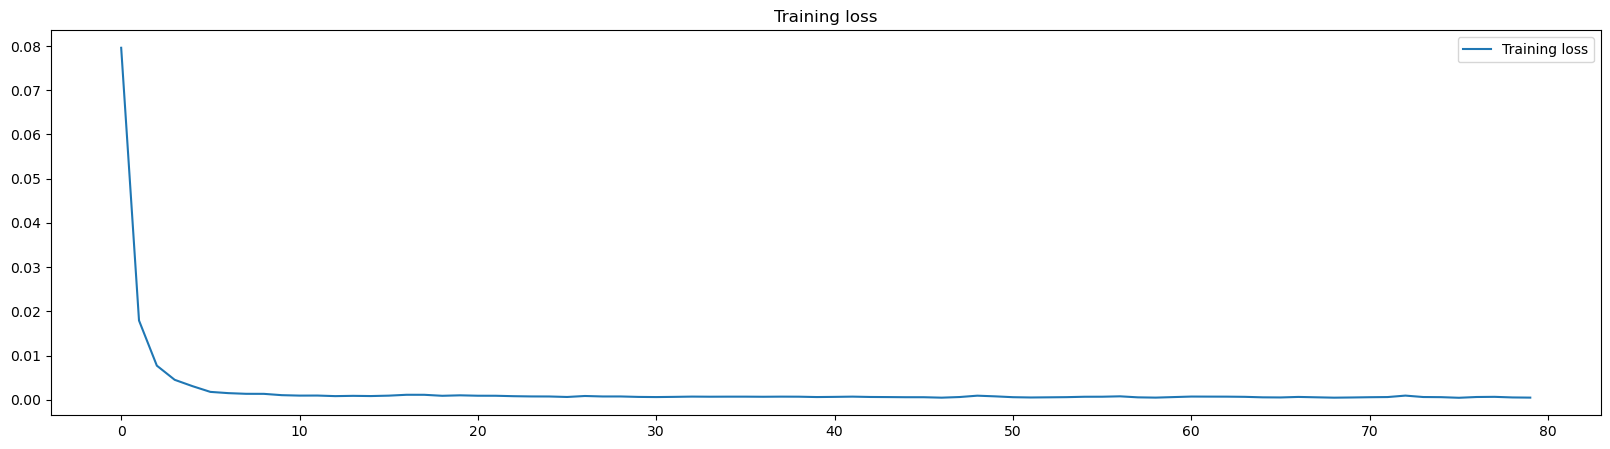

In [11]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.title('Training loss')
plt.legend()

In [12]:
training_dates= df.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

13/13 [==============================] - 0s 13ms/step


In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['şimdi']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [14]:
testing_dates= df.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

1/1 [==============================] - 0s 35ms/step


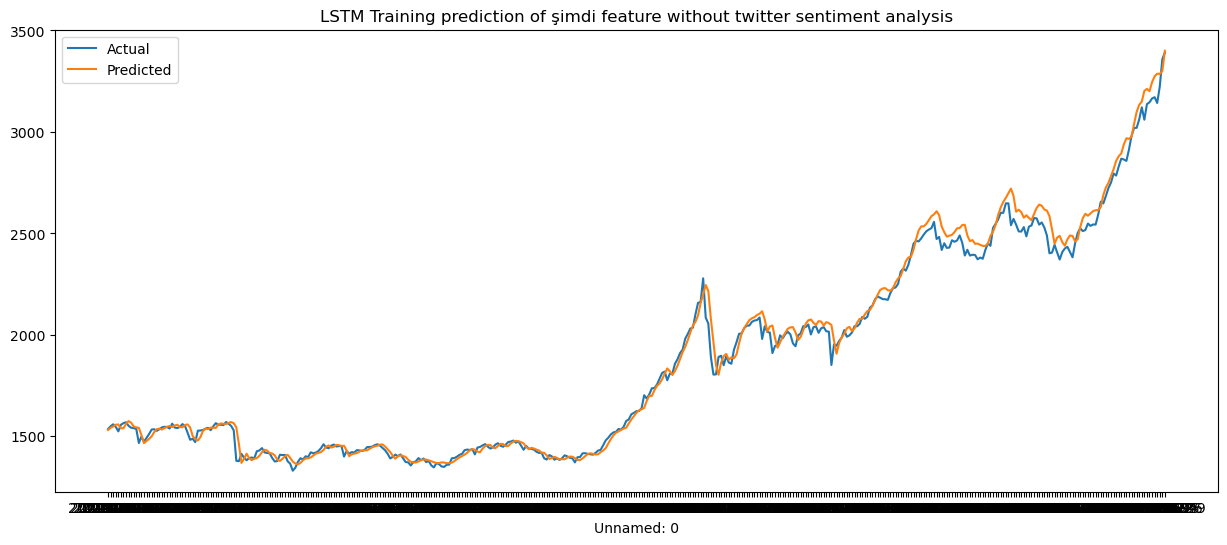

Mean square error for şimdi =2224.3365974246476
Total mean square error 2224.3365974246476


In [15]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm ,y_train_pred_lstm_without_twitter)

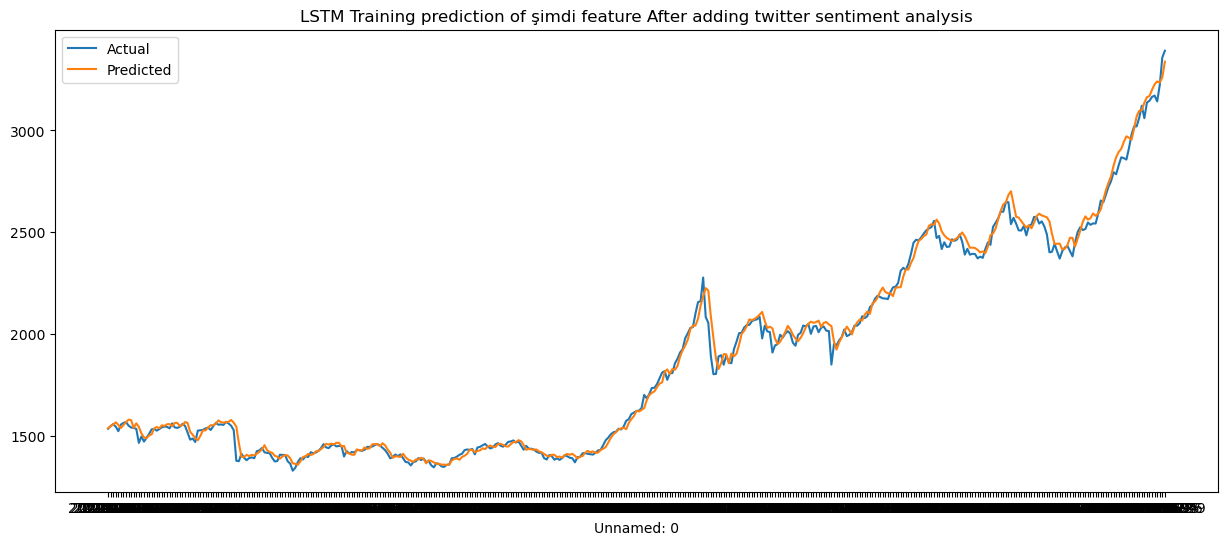

Mean square error for şimdi =1550.2935808576497
Total mean square error 1550.2935808576497


In [16]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm ,y_train_pred_lstm_twitter)

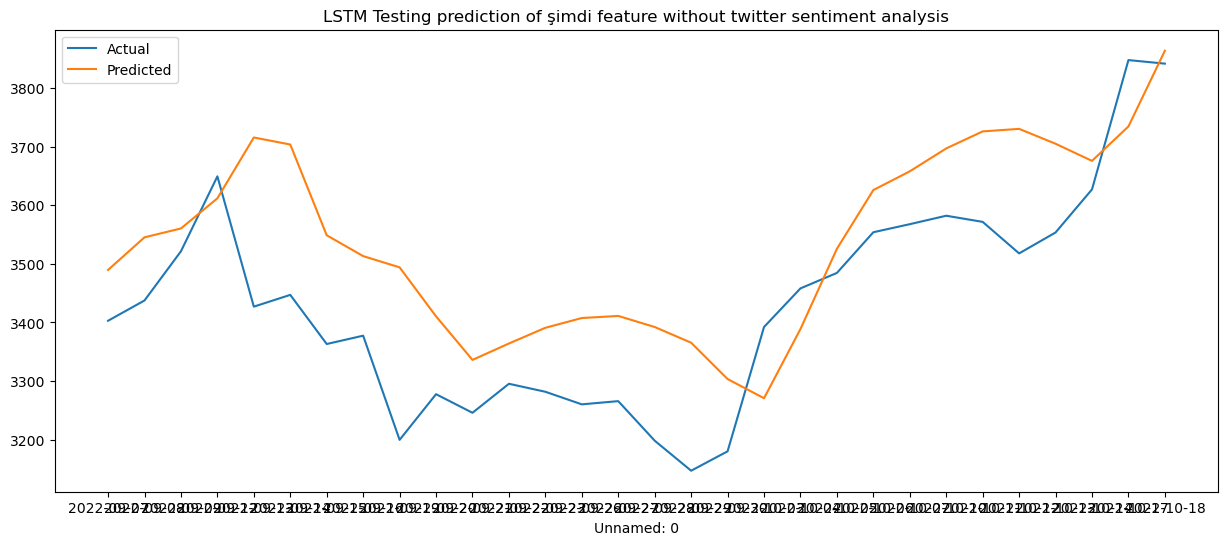

Mean square error for şimdi =21731.769163594327
Total mean square error 21731.769163594327


In [17]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

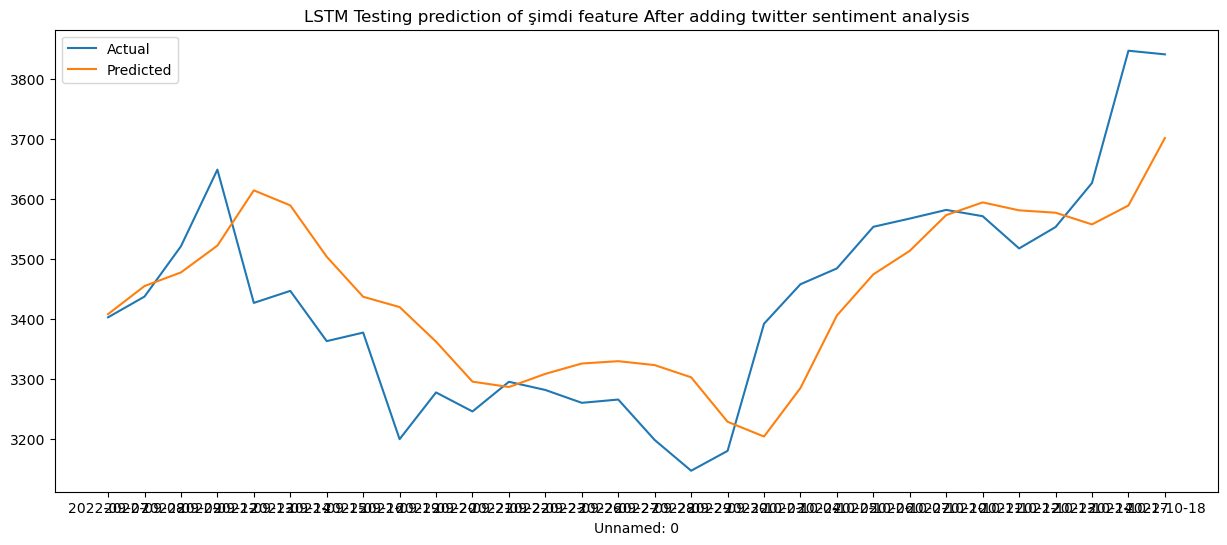

Mean square error for şimdi =12796.720530229446
Total mean square error 12796.720530229446


In [18]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

In [19]:
cnn_lstm_model_twitter.save('d_cnn_lstm_twitter.h5')

In [20]:
from pickle import dump
dump(scaler, open('d_in_scaler.pkl', 'wb'))
dump(scaler_for_inference, open('d_out_scaler.pkl', 'wb'))